In [1]:
# this is written one month before the first working game prototype
# code needs to be updated
# this is largely for demostration and to appreciate why picking peaks in the first octave don't usually work
from IPython.display import clear_output

import pyaudio
import argparse

import numpy as np
import time
import keras
import matplotlib.pyplot as plt

/anaconda3/envs/nd/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import pandas as pd
import numpy as np
import glob
import gc
import keras 
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, MaxPooling2D, Conv2D, Input
from keras.layers import Flatten, BatchNormalization, Activation, Reshape, concatenate
from keras.models import Model
import random
from sklearn.model_selection import KFold
import keras.backend as K

In [3]:
steps = 20
height = 108
width = 108

def main(optimizer='adam', loss='mean_squared_error', metrix='accuracy'):
    #cnn
    cnn_inputs = Input(shape=(height, width, 1), name='cnn_inputs')
    layers = Conv2D(32, (3,3), padding="same", activation="relu")(cnn_inputs)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D(2,2, border_mode='same')(layers)
    layers = Conv2D(32, (3,3), activation='relu')(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D(2,2, border_mode='same')(layers)
    layers = Flatten()(layers)
    layers = Dropout(0.3)(layers)
    layers = Dense(32, activation='relu')(layers)
    
    #lstm
    lstm_inputs = Input(shape=(steps, 24), name='lstm_inputs')
    lstm_layers = LSTM(16, return_sequences=True)(lstm_inputs)
    lstm_layers = LSTM(16)(lstm_layers)
    lstm_layers = Dense(24, activation='relu')(lstm_layers)
    
    #main route
    main_ = concatenate([layers, lstm_layers])
    main_ = BatchNormalization()(main_)
    main_ = Dense(64, activation='relu')(main_)
    output = Dense(24, activation='sigmoid')(main_)
    
    model = Model(inputs=[cnn_inputs, lstm_inputs], outputs=[output])
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrix])
    return model

classifier = main(optimizer='adam', loss='binary_crossentropy')
classifier.load_weights('weight-75-overlap-model2.hdf5')

/anaconda3/envs/nd/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
/anaconda3/envs/nd/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`


In [4]:
def predict(cnn_input, lstm_input, classifier):
    result = classifier.predict([cnn_input, lstm_input])[0].tolist()
#     print(result)
#     output = 'C'
    result_rounded = np.zeros(np.shape(result))
    possible = 'possible notes: '
    for i in range(len(result)):
#         if result[i] < 0.9:
#             result[i] = 0
#         el
         if result[i] > 0.9:
            result_rounded[i] = 1
#             output += '_{}'.format(i+60)
#         else:
#             possible += '_{}__{}'.format(i+60, result[i])
#     print(output)
#     print(possible)
    return result, result_rounded

In [5]:
all(predict(np.zeros((1,108,108,1)), np.zeros((1,20,24)), classifier)[0] == np.zeros(24))

False

In [6]:
import librosa
def convert_to_CQT(signal_to_map):
    fmin = librosa.core.note_to_hz("B3")
    cqt_array = librosa.cqt(signal_to_map, sr=44100, hop_length=2**7, bins_per_octave=36, fmin=fmin, n_bins=108)
    CQT = librosa.magphase(cqt_array)[0][:108,-108:]
#     print(np.shape(CQT))
    return CQT

In [7]:
# this is the size of each individual block of audio, we call this "chunk"
chunksize = 2048

# todo: variable frequency for CQT

# parser = argparse.ArgumentParser()
# parser.add_argument("-input", required=False, type=int, help="Audio Input Device")
# args = parser.parse_args()

# # this is here so you can choose the default audio input
# if args.input is None:
#     print("No input device specified. Printing list of input devices now: ")
#     p = pyaudio.PyAudio()
#     for i in range(p.get_device_count()):
#         print("Device number (%i): %s" % (i, p.get_device_info_by_index(i).get('name')))
#         print("Run this program with -input 1, or the number of the input you'd like to use.")
#         exit()

# starting audio channel?
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paFloat32,
channels=1, rate=44100, input=True,
input_device_index=0, frames_per_buffer=chunksize)
time.sleep(1)

In [8]:
# def detect_onset(signal, chunksize=2048, tempo_res=32, plotting = False):
#     '''
#     # this is to be called at the end of every chunk (2048 entries), starting from 4th chunk
#     # the input to this function is four chunks
#     These are never likely to be changed, maybe? : chunksize=2048, tempo_res=32
    
#     TODO: make become on the fly
#     '''
#     # default value of onset, overwritten if onset is detected
#     onset = -1

#     # to detect difference
#     difference = np.cumsum(np.add(np.absolute(signal[chunksize:-chunksize]), -np.absolute(signal[:-2*chunksize])))
    
#     # white noise is added the the difference 
#     # this is to desensitise detection of low amplitdue onset sounds
#     noise = 10*np.array(np.random.randn(len(difference)))
#     difference = np.add(difference, noise)

#     # calculation of r-coefficient
#     # -1 is negatively correlated
#     # +1 is positively correlated
#     # onset is when r-coefficient cuts above 0.8
#     roceff = np.full(tempo_res, 0.)
#     tempo_num = int(chunksize / tempo_res)
#     for i in range(tempo_res):
# #         print(np.shape(difference))
#         roceff[i] = np.corrcoef(difference[i * tempo_num:(i * tempo_num + chunksize)],
#                                       np.arange(chunksize))[0, 1]
#         # special case when i = 0, because we do not have the previous value
# #         if i == 0 and roceff[0] > 0.8:
# #             onset = i
#         if roceff[0] < 0.8 and roceff[i] > 0.8 and np.max(roceff[:i]) < 0.8:
#             onset = i
    
#     return onset # none, or a value

In [9]:
def note_detect(chunksize=2048, tempo_res=32, plotting = False):
    print("opening")
    frames = []
    i = 0
    
    lstm_history = np.zeros((1,20,24))

    while True:
        # assume pyaudio clip mono sound
        # use assert?
        
        i += 1
        data = stream.read(chunksize, exception_on_overflow=False)
        data = np.fromstring(data, np.float32)
        frames.append(data)
        # print(len(frames))
        
        # start listening only after there is a certain number of "frames"
        if i > 10 and len(frames)>30:
            frames[:] = frames[-30:]
#             signal = np.concatenate((frames[-5],frames[-4],frames[-3],frames[-2]))

            # onset function
            # print(np.sum(abs(signal)))
            # print(len(signal))
            # print("finding onset")
#             onset = detect_onset(signal)
            # print("onset detection complete")
            # print(onset)
            
            # remove the older frames
            
            # make an array consists of 4096 entries if there is an onset
            if True:
#                 print("onset DETECTED")
                signal_ = np.concatenate(frames[:])
                signal_input = signal_[-14336:]
#                 onset = -1 # set onset back to negative one - but necessary?
                
                spectro = convert_to_CQT(signal_input)
                

                
                spectro_ = spectro.reshape(1,108,108,1)
                result, result_rounded = predict(spectro_, lstm_history, classifier)
                
                
                lstm_history[0,:-1] = np.copy(lstm_history[0,1:])
                lstm_history[0,-1] = np.copy(result)
                # OR result_rounded
                # BOTH DOESN'T WORK
                
                if not(all(result_rounded == np.zeros(24))):

                    # clear output from jupyter
                    clear_output(wait=True)
                    plt.figure(figsize=(16,2))
#                     difference = np.cumsum(np.add(np.absolute(signal_input[chunksize:-chunksize]), -np.absolute(signal[:-2*chunksize])))
#                     plt.plot(np.arange(2048*1,2048*3),np.array(difference)/np.max(difference))
#                     plt.plot(np.arange(2048*2,2048*3,64),roceff)
                    plt.plot(signal_input)
                    plt.show()
        
                    plt.imshow(spectro)
                    plt.show()
                    print(result)
                    print(result_rounded)
                    print(lstm_history)

                    plt.show()
                    
#                     break

    # don't you need to return something?

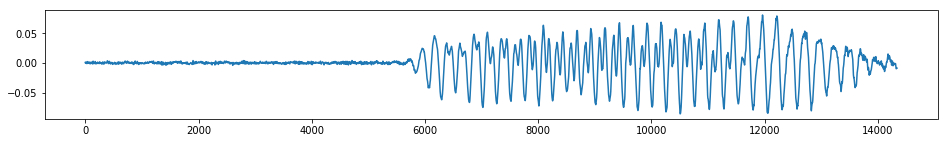

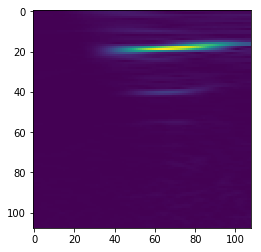

[0.0004619236569851637, 0.00018724259280133992, 0.0008880646200850606, 0.00048785595572553575, 0.9821726679801941, 1.0, 0.9967515468597412, 5.4091236961539835e-05, 2.8296179152675904e-05, 0.000667778542265296, 0.004089617170393467, 0.00530206086114049, 0.009807719849050045, 0.9709587693214417, 5.2206843975000083e-05, 3.9133676182245836e-05, 5.974213490844704e-05, 0.029829207807779312, 0.010437016375362873, 0.0004522634553723037, 0.00012130637333029881, 0.0007143523544073105, 1.822926424210891e-05, 5.9164241974940524e-05]
[0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[[3.46014684e-04 2.93589139e-04 9.16652556e-04 8.49586737e-04
   9.29510687e-04 3.16322315e-03 5.20689704e-04 1.41559762e-03
   4.11036344e-05 7.97637796e-04 4.44881734e-04 6.05066540e-04
   2.12171092e-03 2.66218092e-04 2.91586784e-03 1.59579061e-03
   1.50865479e-03 9.24758206e-04 2.55853077e-03 1.20740372e-03
   2.63410178e-03 4.89215483e-04 1.01481122e-03 3.86986270e-04]
  [3.04907910e-04 2.

In [ ]:
note_detect()

In [ ]:
import numpy as np
lstm_history_ = np.zeros((20,24))

In [ ]:
lstm_history_[:-1] = lstm_history_[1:]
lstm_history_[-1] = np.zeros(24)
lstm_history_

In [ ]:
a = [[1,3],[3,4]]
np.concatenate(a[:])